In practice, true stationarity or cointegration is rare. 
And even if the series is stationary, if the half-life for mean reversion is too long (e.g., 10 years), it will not be viable. 
However, we can capture short-term or seasonal mean reversion (time series that mean-revert only during specific periods of the day or under specific conditions), and liquidate our positions before the prices go to their nex equilibrium level. 


In [501]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from hurst import compute_Hc
from arch.unitroot import VarianceRatio
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler


We trade a pair of stocks with price series $y_1, y_2$. We construct a portfolio $y$:

$$ y = y_1 - h y_2 $$

where we are long stock 1 and short $h$ units of stock 2. 

## Load price series

In [482]:
tickers = ['KO', 'PM']
period = '2y'
interval = '1h'

In [483]:
prices = [yf.Ticker(t).history(period=period, interval=interval)['Close'] for t in tickers]
prices_df = pd.DataFrame({ticker: price_series[(prices[0].index[:-1])] for ticker, price_series in zip(tickers, prices)})
prices_df

,KO,PM
2021-12-06 09:30:00-05:00,54.996300,90.875000
2021-12-06 10:30:00-05:00,55.014999,91.379997
2021-12-06 11:30:00-05:00,55.165001,91.459999
2021-12-06 12:30:00-05:00,55.115002,91.584801
2021-12-06 13:30:00-05:00,55.084999,91.670097
...,...,...
2023-12-04 09:30:00-05:00,58.830002,94.349998
2023-12-04 10:30:00-05:00,58.715000,94.055000
2023-12-04 11:30:00-05:00,58.548100,93.220001
2023-12-04 12:30:00-05:00,58.685001,92.699997


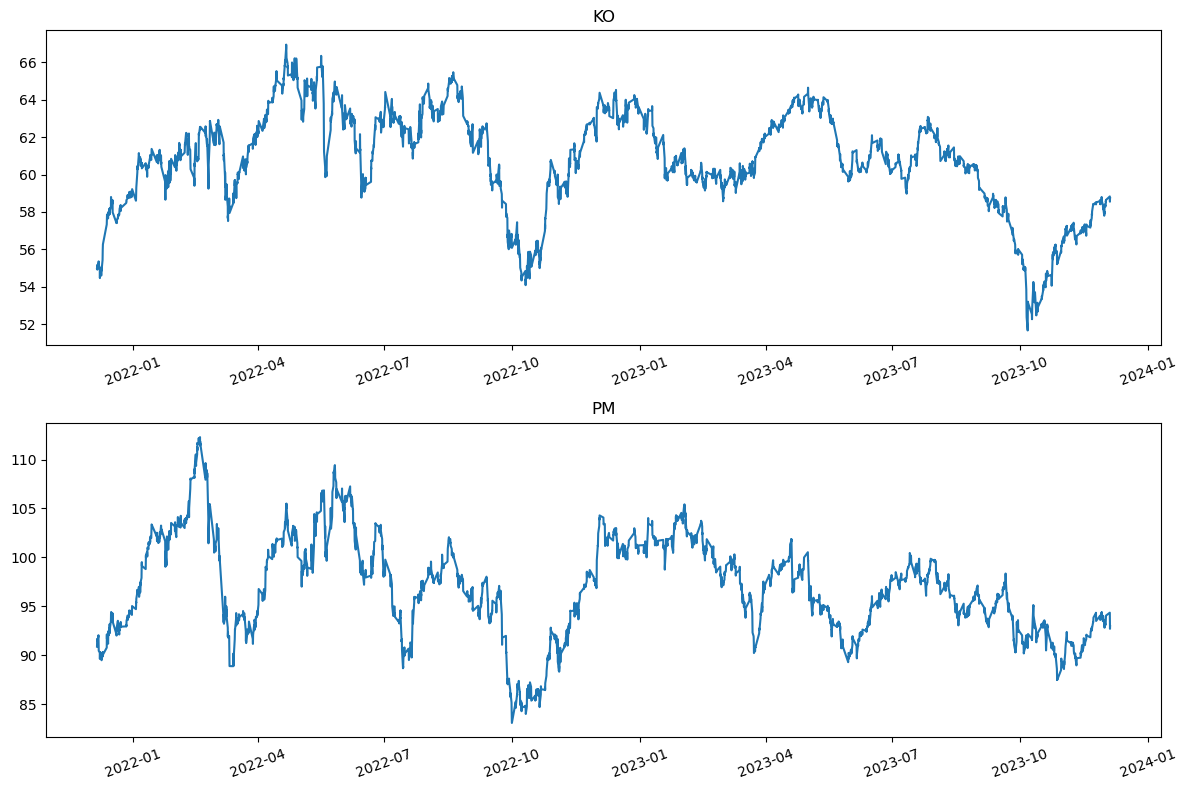

In [484]:
fig, axs = plt.subplots(len(prices), figsize=(12, 8))

for i in range(len(prices)):
    axs[i].plot(prices[i].index, prices[i])
    axs[i].set_title(tickers[i])
    axs[i].tick_params(axis='x', labelrotation=20)

plt.tight_layout()
plt.show()

## Create long/short pair portfolio

First we find the optimal hedge ratio through OLS regression. 

In [485]:
hedge_ratio = sm.OLS(prices[0][:-1], sm.add_constant(prices[1][:-1])).fit().params[1]
hedge_ratio

0.3427077649455823

Then we construct the optimally hedged portfolio.

<AxesSubplot: >

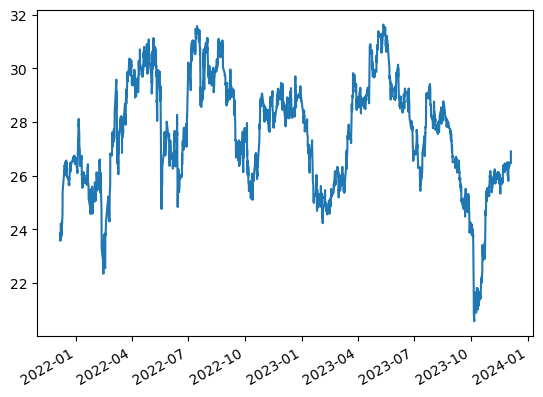

In [486]:
portfolio = (prices[0][:-1] - hedge_ratio * prices[1][:-1])
portfolio.plot()

## Test mean-reversion of portfolio

First we perform an Augmented Dickey-Fuller (ADF) test on the two portfolios, which indicates that the portfolio is stationary. 

In [487]:
adfuller(portfolio)

(-3.3148550802406644,
 0.01422737040871298,
 1,
 3501,
 {'1%': -3.4322192091147468,
  '5%': -2.862365910492847,
  '10%': -2.567209646484487},
 -903.8175560463778)

We see that the Hurst exponent for the portfolio is $<1/2$, which indicates antipersistence and mean-reversion. 

In [488]:
compute_Hc(portfolio)

(0.4283064395747144,
 1.7665979376013665,
 [[10, 17, 31, 56, 100, 177, 316, 562, 1000, 1778, 3162, 3503],
  [3.84623767915989,
   5.402029880626998,
   7.57396645792641,
   9.928327525404764,
   13.597981728152513,
   19.518957879303812,
   26.668676394414625,
   33.480186269874565,
   36.44242593255697,
   38.42418257368819,
   43.540780137877945,
   52.08492917332244]])

We also conduct a variance ratio test where we see that we can't reject the null hypothesis that the variance is constant over time for significance $0.05$. 

In [489]:
print(VarianceRatio(portfolio).summary().as_text())

     Variance-Ratio Test Results     
Test Statistic                  1.010
P-value                         0.313
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)


## Half-life

If we transform the discrete time series from above to a differential form so that the changes in prices becomes infinitesimal quantities (and ignore the drift $\beta_t$ and the lagged differences $\Delta R(t-1), ..., \Delta R(t-k)$) then it becomes recognizable as the Ornstein-Uhlenbeck formula for a mean-reverting process
$$ d R(t) = (\lambda R(t-1) + \mu)dt + d\epsilon $$
where $d \epsilon$ is some Gaussian noise. 
We find the $\lambda$ using the ADF test, where we apply linear regression of $\Delta R(t)$ against $R(t-1)$, and this value carries over to the differential form. 
The analytical solution for the expected value of $R(t)$ is
$$ E[R(t)] = R_0 \exp{(\lambda t)} - \mu / \lambda (1-\exp{(\lambda t)}) $$

Since $\lambda$ is negative for a mean-reverting process, the expected value of the price decays exponentially to the value $-\mu/\lambda$ with the half-life of decay equal to $-\log{(2)}/\lambda$. 
Therefore, a mean-reverting strategy will not work if $\lambda>0$. 
Furthermore, if $\lambda$ is very close to zero, this means that the half-life will be very long, and a mean-reverting strategy will not be very profitable because we won't be able to complete many round-trip trades in a given time period. 
Lastly, $\lambda$ determines a natural time scale for many parameters in our strategy. Often, setting the look-back to equal a small multiple ($\geq 1$) of the half-life is close to optimal. 

In [490]:
def get_halflife(y): 
    ylag = np.roll(y, 1)
    deltaY = y - ylag
    deltaY = deltaY[1:]
    ylag = ylag[1:]
    X = np.column_stack((ylag, np.ones(len(ylag))))
    ols_model = sm.OLS(deltaY, X).fit()
    beta_1 = ols_model.params[0]
    halflife = -np.log(2) / beta_1
    return halflife

In [491]:
lookback = int(get_halflife(portfolio))
lookback

126

## Bollinger Bands

We enter into a position when the price deviates by more than $entryZscore$ standard deviations from the mean (computed within a look-back period or equal to the half-life of mean reversion). 

We exit when the price mean-reverts to $exitZscore$ standard deviations from the mean, where $exitZscore < entryZscore$. 

If $exitZscore=0$, we exit when the price mean-reverts to the current mena. 
If $exitZscore=-entryZscore$, we exit when the price moves beyond the opposite band so as to trigger a trading signal of the opposite sign. 

At any one time, we can have either zero or one unit (long or short) invested. 


In [522]:
entryZscore = 1
exitZscore = 0

In [523]:
zScore = pd.DataFrame(((portfolio - portfolio.rolling(window=lookback).mean()) / portfolio.rolling(window=lookback).std()), index=portfolio.index)
zScore

,Close
2021-12-06 09:30:00-05:00,NaN
2021-12-06 10:30:00-05:00,NaN
2021-12-06 11:30:00-05:00,NaN
2021-12-06 12:30:00-05:00,NaN
2021-12-06 13:30:00-05:00,NaN
...,...
2023-12-04 09:30:00-05:00,1.810733
2023-12-04 10:30:00-05:00,1.718529
2023-12-04 11:30:00-05:00,2.138507
2023-12-04 12:30:00-05:00,3.214252


In [524]:
longsEntry = zScore < -entryZscore
longsExit = zScore >= -exitZscore
shortsEntry = zScore > entryZscore
shortsExit = zScore <= exitZscore

We find the long entries and exits

<AxesSubplot: >

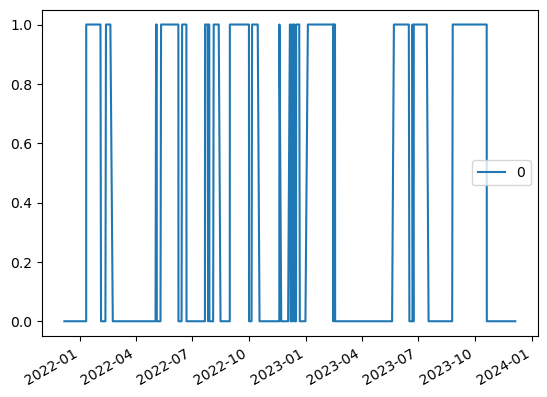

In [525]:
numUnitsLong = np.full((len(portfolio), 1), np.nan)
numUnitsLong[0] = 0
numUnitsLong[longsEntry] = 1
numUnitsLong[longsExit] = 0
numUnitsLong = pd.DataFrame(numUnitsLong, index=portfolio.index).ffill()#.to_numpy()
numUnitsLong.plot()

We find the short entries and exits 

<AxesSubplot: >

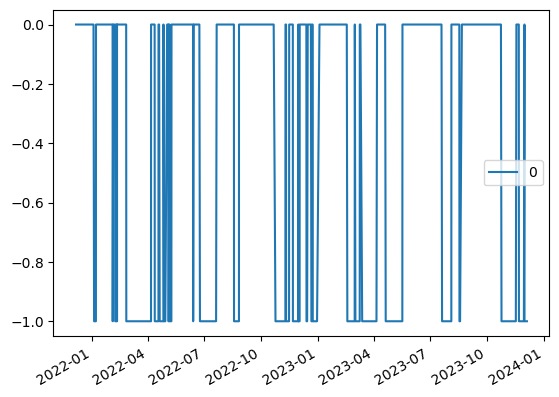

In [526]:
numUnitsShort = np.full((len(portfolio), 1), np.nan)
numUnitsShort[0] = 0
numUnitsShort[shortsEntry] = -1
numUnitsShort[shortsExit] = 0
numUnitsShort = pd.DataFrame(numUnitsShort, index=portfolio.index).ffill()#.to_numpy()
numUnitsShort.plot()

We then combine the long and short entries and exits to form our holdings of the portfolio. 

<AxesSubplot: >

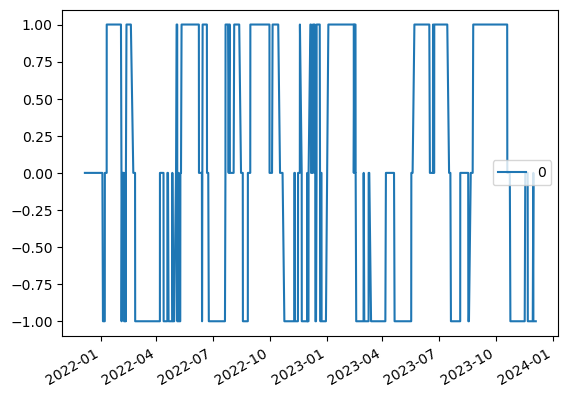

In [527]:
numUnits = numUnitsLong + numUnitsShort
numUnits.plot()

Following this strategy produces the following returns. 

<AxesSubplot: >

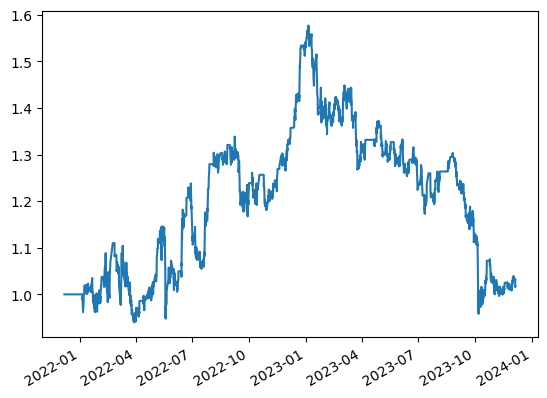

In [528]:
pnl = portfolio.pct_change(1)[1:] # the returns of the portfolio
pnl *= numUnits[:-1].values.flatten() # times our position
pnl = pnl.add(1).cumprod() # getting the cumulative product of our returns
pnl.plot()

Scaling into position with a mean-reverting strategy is common. As the price deviates further from its mean, the potential profit to be reaped from an eventual reversal is also increasing; this, it makes sense to increase the capital invested. This also applies to gradually taking profits by scaling out of the position when the price reverts to the mean. Scaling in and out is advantageous when the price series is not really stationary (which in practice is usually true) and also reduces market impact. 

The simple strategy would be to create multiple entry and exit points using Bollinger bands, i.e., $entryZscore = 1, 2, 3, ..., N$. However, this was proven by Schoenberg and Corwin to never be optimal. That is, you can always find a single entry and exit point that will generate higher returns. 

## Kalman Filter

In the example above we calculated the optimal hedge ratio using OLS regression on historical data. This works well for truly cointegrating assets. However, in practice the prices are not fully cointegrating and this hedge ratio will vary with time. 
A simple idea is to use a moving average over historical prices to continously update the hedge ratio. However, this might create abrupt swings in the hedge ratio, and choosing a weighting scheme not trivial. A better way is using the Kalman filter. 

The Kalman filter is an optimal linear algorithm that updates the expected value of a hidden variable based on the latest value of an observed variable. 
It assumes that the observable variable is a linear function of the hidden variable with noise. 
The Kalman filter is optimal in the sense that it is the best estimator if we assume that the noises are Gaussian, and it minimizes the MSE of the estimated variables. 


In the context of mean-reversion, the dynamic linear regression model represents the evolving relationship between the current price and its historical mean.


The relationship between the observable price series $y$, and the hedge ratio (hidden variable) $\beta$, is the linear function 

$$ y(t)=x(t)\beta (t) + \epsilon (t) $$

where $x$ is the price series of the other asset, and $\epsilon$ is Gaussian noise with variance $V_\epsilon$. 

We assume that the regression coefficient (our hidden variable) at time $t$ is the same as that at time $t-1$ plus noise

$$ \beta (t) = \beta (t-1) + \omega (t-1) $$
where $\omega$ is Gaussian noise with covariance $V_\omega$. In other words, the state transition model here is just the identity matrix. 

Set up the Kalman filter using pykalman

In [594]:
delta = 1e-5 
trans_cov = delta / (1 - delta) * np.eye(2)
obs_mat = np.vstack(
    [prices_df[tickers[0]], np.ones(prices_df[tickers[0]].shape)]
).T[:, np.newaxis]

In [595]:
kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )

We get the hidden variable $\beta$. It contains two parts: the slope (the hedge ratio) and intercept (the MA of the spread). 

In [596]:
state_means, state_covs = kf.filter(prices_df[tickers[1]].values)

Now we have the state means $\beta$ and can plot the optimal hedge ratio and MA of the spread. 

<AxesSubplot: >

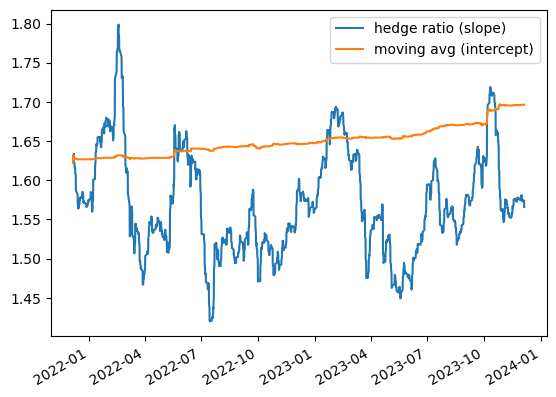

In [597]:
state_means_df = pd.DataFrame(np.array(state_means), index=prices_df.index)
state_means_df.columns = ['hedge ratio (slope)', 'moving avg (intercept)']
state_means_df.plot()

## Kalman Filter as Market-Making Model

Let $y(t)$ be the price series and the observable variable with mean $m(t)$, which in this case is the hidden variable.
The measurment equation is
$$ y(t) = m(t) + \epsilon (t) $$
with the state transition equation
$$ m(t) = m(t-1) + \omega (t-1) $$
So the state update equation is
$$ m(t|t) = m(t|t-1) + K(t) (y(t) - m(t|t-1)) $$

The variance of the forecast error is 
$$ Q(t) = Var(m(t)) + V_e $$
The Kalman gain is 
$$ K(t) = R(t|t-1)/(R(t|t-1)+V_e) $$
and the state variance update is
$$ R(t|t) = (1-K(t))R(t|t-1) $$

This is a common model for market makers to update their estimate of the mean price of an asset. To make these equation more practical, practicioners make further assumptions about the measurement error $V_e$, which measures the uncertainty of the observed transaction price. We can interpret this uncertainty such that if the trade size is large (compared to some benchmark), then the uncertainty is small, and vice versa. So $V_e$ becomes a function of $t$ as well. If we denote the trade size as $T$ and the benchmark trade size as $T_{max}$, the $V_e$ can have the form
$$ V_e = R(t|t-1)\left(\dfrac{T}{T_{max}}-1 \right) $$

So if $T=T_{max}$, there is no uncertainty in the observed price, and the Kalman gain is 1, and hence the new estimate of the mean price $m(t)$ is equal to the observed price. $T_{max}$ can be defined as some fraction of the total trading volume of the previous day. 